In [7]:
# Develop a metric for distinguising a 'nice' chromatograph from noise
# plan:
#    manually extract 20 'nice' chromatographs & 20 'nasty' chromatographs & 20 double or tripple peak chromatographs
#    test a few scores to see which gives good separation
#    - kurtosis
#    - variance of maxima along each pixel row (wont detect overlapping peaks unless do centroid detection)
#    - define 'peak width' and keep fitting gaussians until sigma gets 'large'
# also need to do centroid detection on the chromatograms.

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
#sys.path.append('/Users/palmer/Documents/python_codebase/')
#sys.path.append("/Users/palmer/Documents/python_codebase/pyimzML")
import pyImagingMSpec
import pyMSpec
from pyMSpec import centroid_detection
from pyMSpec import smoothing
from pyImagingMSpec import inMemoryIMS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
filename = "/Volumes/alexandr/shared/imagingMS/External/Private/UMel/BerinBoughton/140802_TLC_mosquito-DHB_01.imzML"
filename = "/Users/palmer/ownCloud/tlc/140802_TLC_mosquito-DHB_01.imzML"

In [51]:
ims_dataset = inMemoryIMS.inMemoryIMS(filename)
ppm=6.
mean_spec = ims_dataset.generate_summary_spectrum(ppm=ppm, summary_type='freq')
mean_spec_c = centroid_detection.gradient(np.asarray(mean_spec[0]),np.asarray(mean_spec[1]), min_intensity=3.)
print len(mean_spec_c[0])
print len(ims_dataset.coords)

TODO: convert indices into real world coordinates
loaded spectra
file loaded
generating histogram axis for ppm 6.0
0
1203


<IPython.core.display.Javascript object>


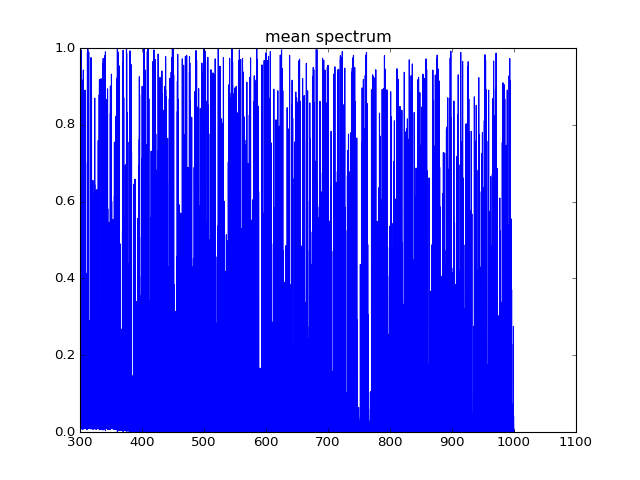

In [52]:
plt.figure()
plt.plot(np.asarray(mean_spec[0]),np.asarray(mean_spec[1]))
plt.title('mean spectrum')
plt.show()

<IPython.core.display.Javascript object>


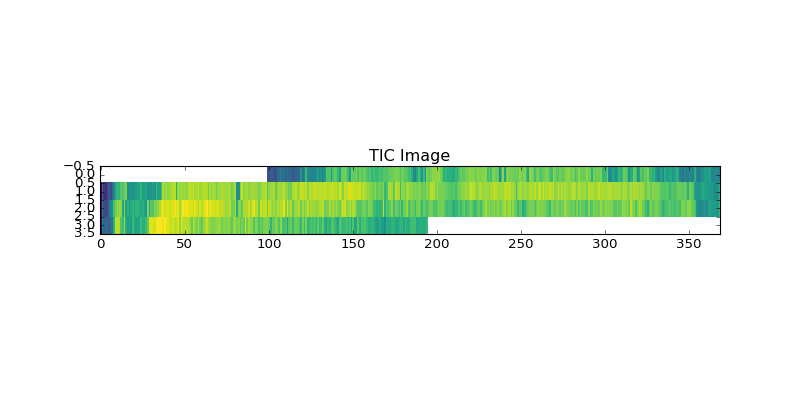

<IPython.core.display.Javascript object>


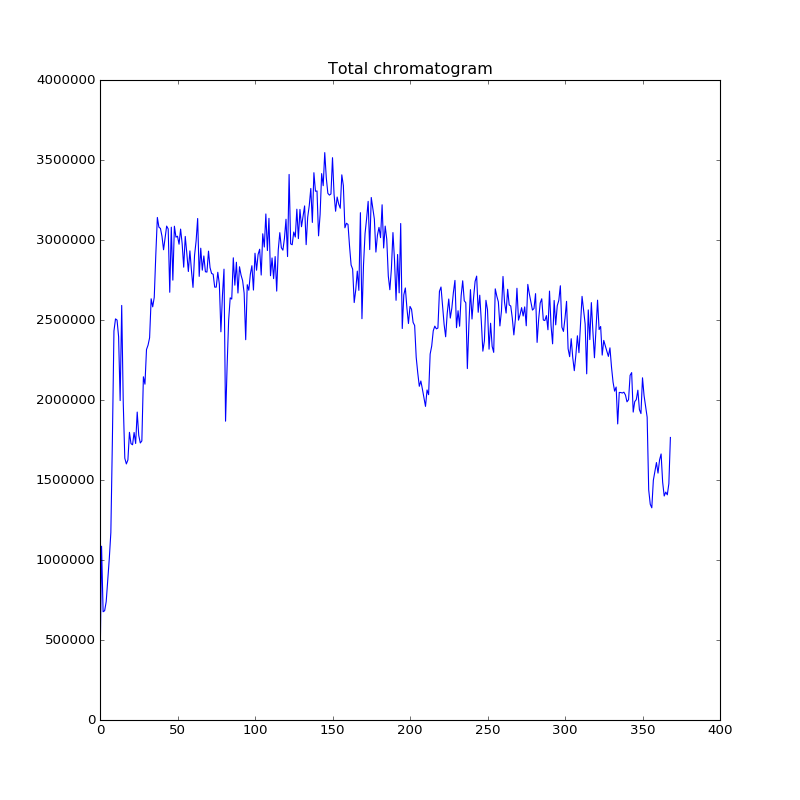

In [12]:
ion_datacube = ims_dataset.get_summary_image()
im=ion_datacube.xic_to_image(0)
plt.figure(figsize=(10,5))
plt.imshow(np.sqrt(im),cmap='viridis',aspect=10., interpolation='nearest')
plt.title('TIC Image')
plt.show()

plt.figure(figsize=(10,10))
plt.plot(np.mean(im,axis=0),color='blue')
plt.title('Total chromatogram')
plt.show()

<IPython.core.display.Javascript object>


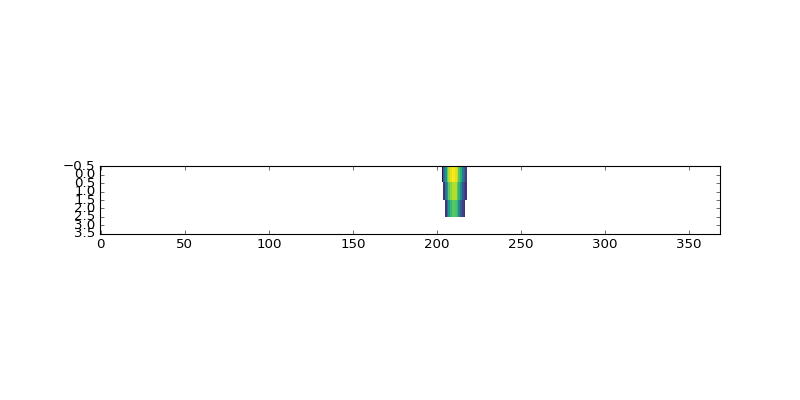

<IPython.core.display.Javascript object>


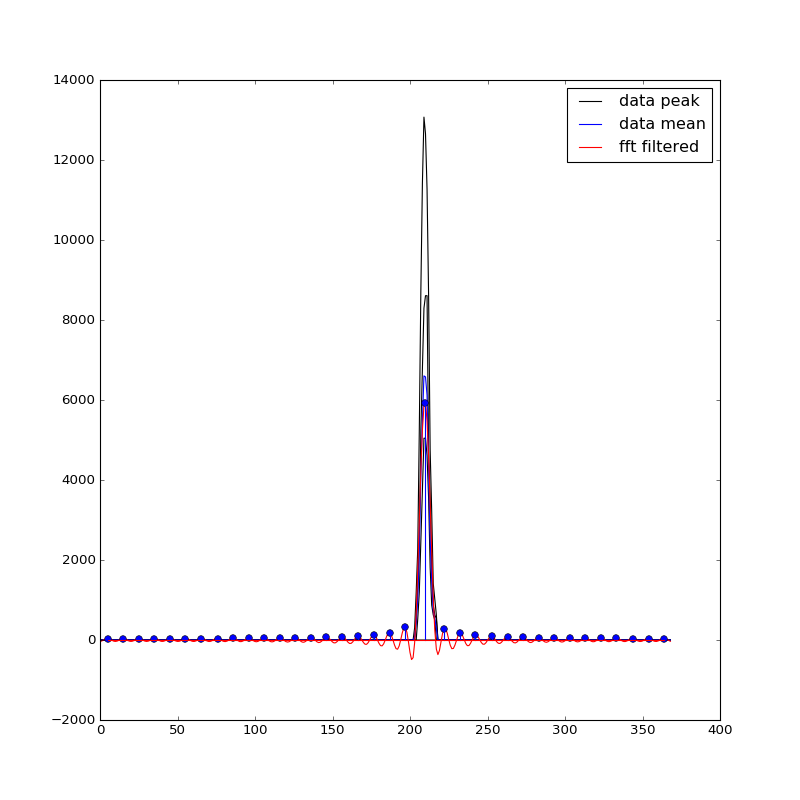

/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


<IPython.core.display.Javascript object>


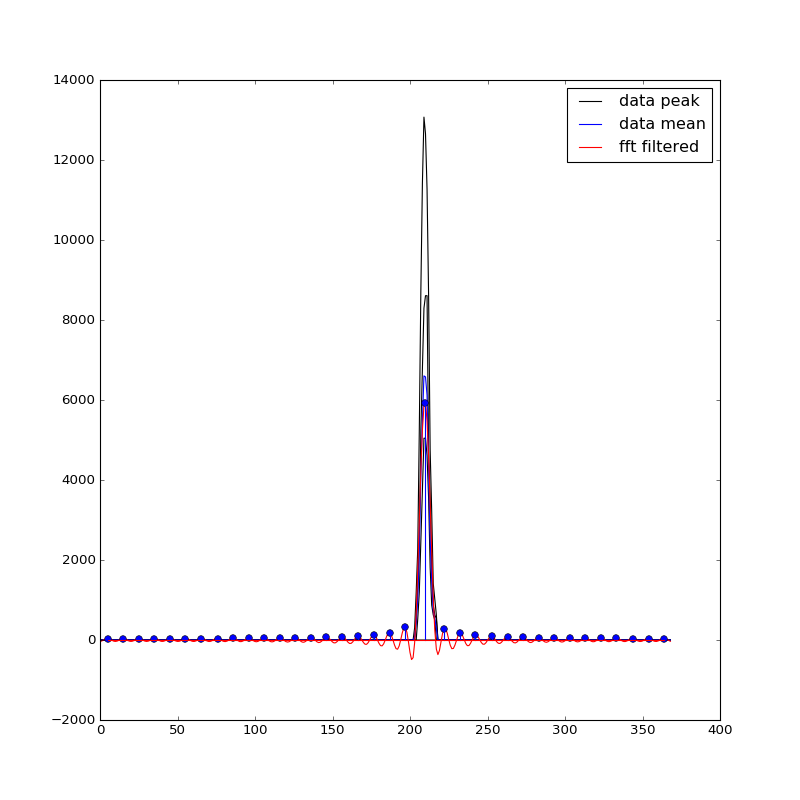

<IPython.core.display.Javascript object>


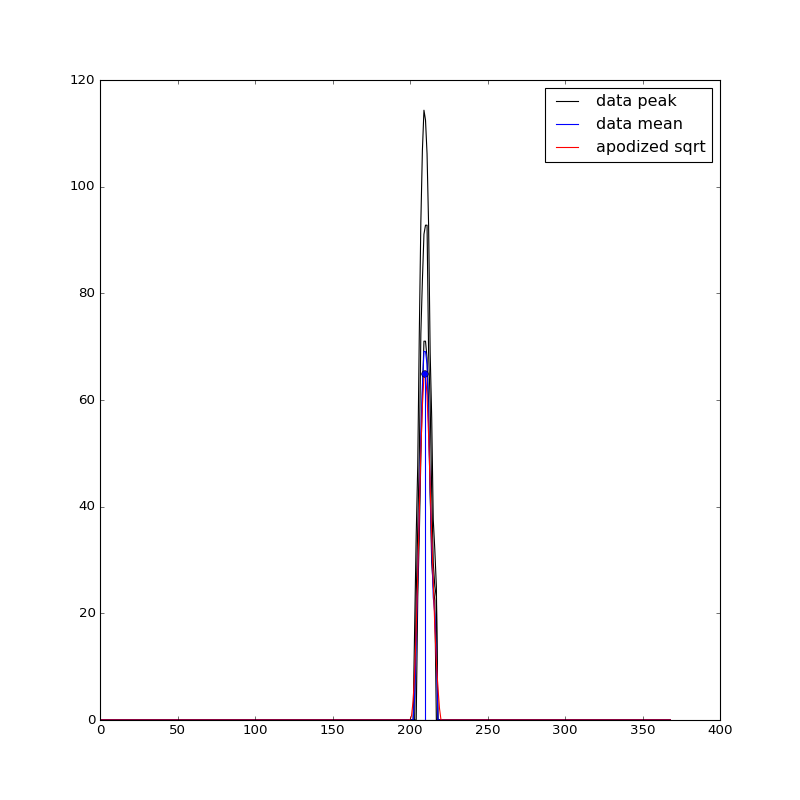

<IPython.core.display.Javascript object>


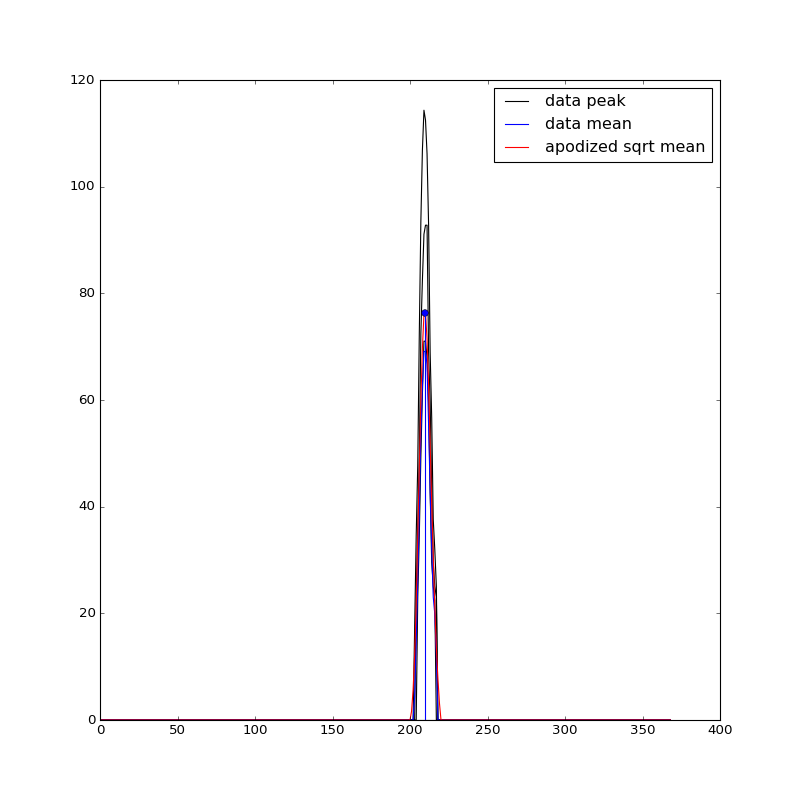

In [13]:
def do_peak_plot(im, m_s, m_s_f,label):
    plt.figure(figsize=(10,10))
    for x in range(im.shape[0]):
        if x==1:
            plt.plot(im[x,:],color="black", label='data peak')
        else:
            plt.plot(im[x,:],color="black")
    plt.plot(np.mean(im,axis=0),color='blue', label='data mean')
    plt.plot(m_s_f,color='red', label=label)
    m_s_f_c = centroid_detection.gradient(np.asarray(range(np.shape(m_s_f)[0])), np.asarray(m_s_f), min_intensity=1.)
    if not m_s_f_c[0] == []:
        plt.stem(m_s_f_c[0], m_s_f_c[1])
    plt.legend()
    plt.show()

## Test data pre-processing
import pyImagingMSpec.smoothing as im_smoothing
#mz=754.529
#mz=823.541
#mz = 725.556
mz=788.5161
ion_datacube = ims_dataset.get_ion_image(mz,[ppm,])
im_raw=ion_datacube.xic_to_image(0)
im=im_smoothing.median(im_raw,size=3)
plt.figure(figsize=(10,5))
plt.imshow(np.log(im),cmap='viridis',aspect=10., interpolation='nearest')
plt.show()

#### chromatogram smoothing ####
m_s = np.mean(im,axis=0)
f = np.fft.fft(m_s)
freq = np.fft.fftfreq(m_s.shape[-1])
f[np.abs(freq)>0.1]=0
m_s_f = np.fft.ifft(f).real
label='fft filtered'
do_peak_plot(im, m_s, m_s_f,label)

## FFT Apodization
w=5
m_s = np.mean(im,axis=0)
f = np.fft.fft(m_s)
freq = np.fft.fftfreq(m_s.shape[-1])
f[np.abs(freq)>0.1]=0
m_s_f = np.fft.ifft(f).real
m_s_f_s = smoothing.apodization(range(len(m_s)),m_s_f,w_size=w)[1]
do_peak_plot(im, m_s, m_s_f,label)

## Sqrt Apodization
sqrt_im = np.nan_to_num(np.sqrt(im.copy()))
m_s = np.mean(sqrt_im,axis=0)
m_s_f = smoothing.apodization(range(sqrt_im.shape[0]),np.mean(sqrt_im,axis=0),w_size=w)[1]
label = 'apodized sqrt'
do_peak_plot(sqrt_im, m_s, m_s_f,label)

## Sqrt Apodization
m_s = np.nan_to_num(np.sqrt(np.mean(im,axis=0)))
m_s_f = smoothing.apodization(range(m_s.shape[0]),m_s,w_size=w)[1]
label = 'apodized sqrt mean'
do_peak_plot(sqrt_im, m_s, m_s_f,label)

In [14]:
import scipy.stats as stats
def smooth_chrom(m_s,w_size=50):
    #f = np.fft.fft(m_s)
    #freq = np.fft.fftfreq(m_s.shape[-1])
    #f[np.abs(freq)>0.1]=0
    #m_s_f = np.fft.ifft(f).real
    #m_s_f_s = smoothing.apodization(range(len(ms)),m_s_f,w_size=w_size)[1]
    m_s[m_s<0]=0
    m_s = np.nan_to_num(np.sqrt(m_s))
    m_s_f_s = smoothing.apodization(np.arange(len(m_s)), m_s, w_size=w)[1]
    return m_s_f_s

n_peaks = []
max_i=[]
kur = []
ion_datacube = ims_dataset.get_ion_image(mean_spec_c[0],[ppm,])
w=10
min_int = 15.
for ii,m in enumerate(mean_spec_c[0]):
    im=ion_datacube.xic_to_image(ii)
    im=im_smoothing.median(im,size=3)
    m_s = np.mean(im,axis=0)
    m_s_f_s = smooth_chrom(m_s, w_size=w)
    m_s_f_s_c = centroid_detection.gradient(np.asarray(range(len(m_s_f_s))), np.asarray(m_s_f_s), min_intensity=min_int)
    n_peaks.append(len(m_s_f_s_c[0]))
    max_i.append(np.max(m_s_f_s))
    kur.append(stats.kurtosis(m_s))

In [15]:
print np.shape(im)

(4, 369)


<IPython.core.display.Javascript object>


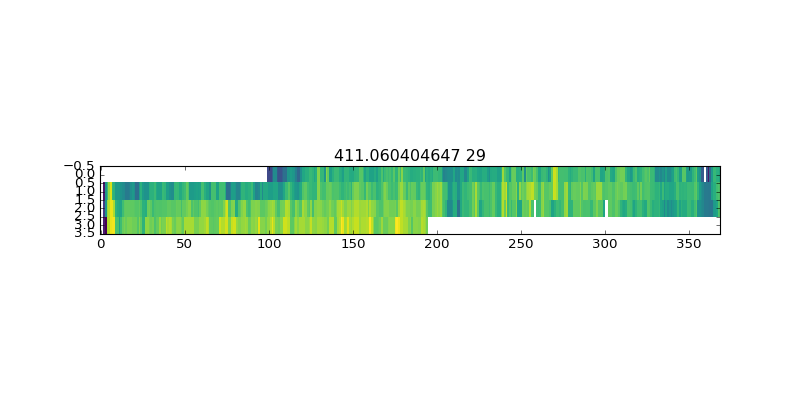

<IPython.core.display.Javascript object>


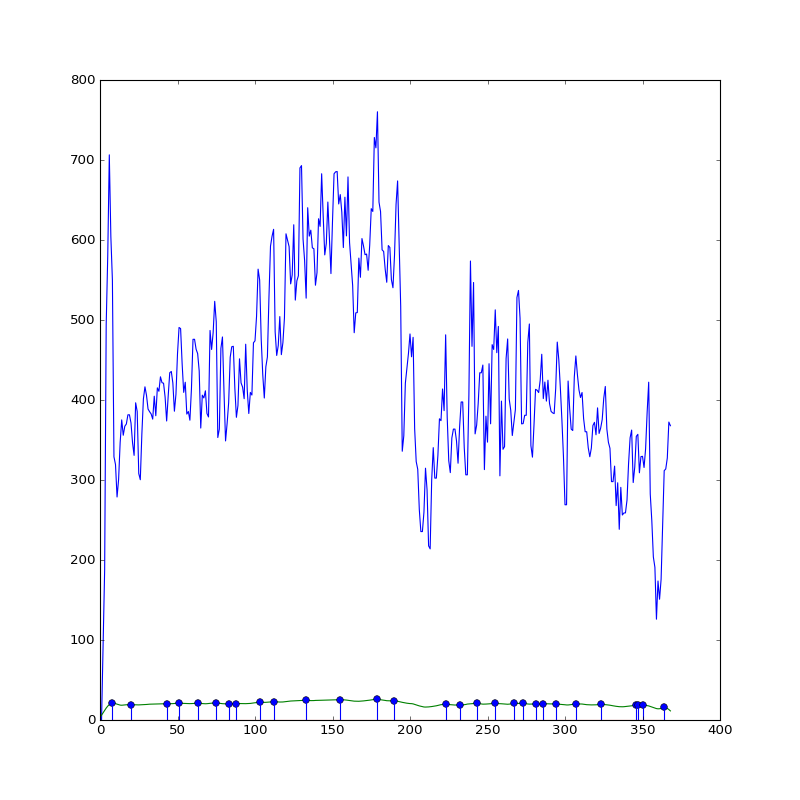

In [16]:
# Check some edge-cases
ion_datacube = ims_dataset.get_ion_image(mean_spec_c[0][np.argmax(n_peaks)],[ppm,])
im = ion_datacube.xic_to_image(0)
im=im_smoothing.median(im,size=3)
plt.figure(figsize=(10,5))
plt.imshow(np.log(im),cmap='viridis',aspect=10., interpolation='nearest')
plt.title("{} {}".format(ion_datacube.mzs[0], np.max(n_peaks)))
plt.show()

m_s = np.mean(im,axis=0)
m_s_f_s = smooth_chrom(m_s, w_size=w)
m_s_f_s_c = centroid_detection.gradient(np.asarray(range(np.shape(m_s_f)[0])), np.asarray(m_s_f_s), min_intensity=min_int)
plt.figure(figsize=(10,10))
plt.plot(m_s)
plt.plot(m_s_f_s)
plt.stem(m_s_f_s_c[0],m_s_f_s_c[1])
plt.show()


<IPython.core.display.Javascript object>


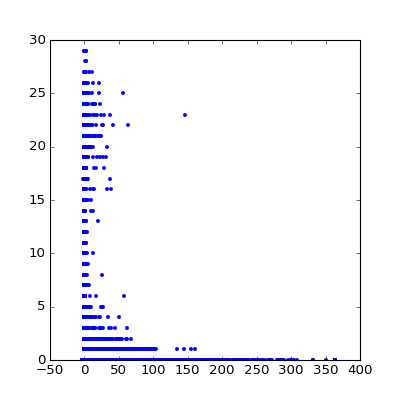

<IPython.core.display.Javascript object>


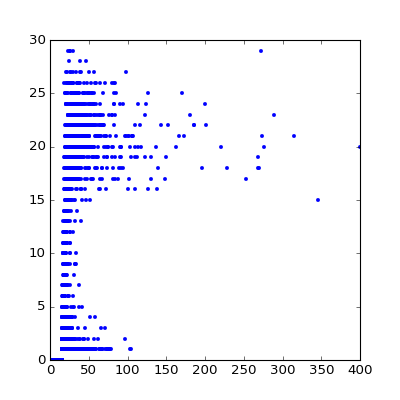

<IPython.core.display.Javascript object>


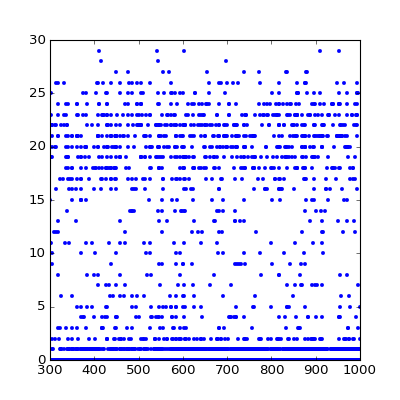

In [17]:
plt.figure(figsize=(5,5))
plt.plot(kur,n_peaks,'.')
plt.show()

plt.figure(figsize=(5,5))
plt.plot(max_i, n_peaks,'.')
plt.show()

plt.figure(figsize=(5,5))
plt.plot(mean_spec_c[0], n_peaks,'.')
plt.show()



In [18]:
# make ion image of each mz in the feature list
# detect chromatogram peaks -> list of feature vectors (mz,rt)
max_features = 3 # largest number of chromatographic peaks acceptable
ion_datacube = ims_dataset.get_ion_image(mean_spec_c[0],[ppm,])
feature_vector = []
for ii,m in enumerate(mean_spec_c[0]):
    im=ion_datacube.xic_to_image(ii)
    im=im_smoothing.median(im,size=3)
    m_s = np.mean(im,axis=0)
    m_s_f_s = smooth_chrom(m_s, w_size=w)
    m_s_f_s_c = centroid_detection.gradient(np.asarray(range(np.shape(m_s_f)[0])), np.asarray(m_s_f_s), min_intensity=min_int, weighted_bins=4)
    if len(m_s_f_s_c[0]) < max_features:
        for rt,ii in zip(m_s_f_s_c[0],m_s_f_s_c[1]):
            feature_vector.append([m,rt,ii])

<IPython.core.display.Javascript object>


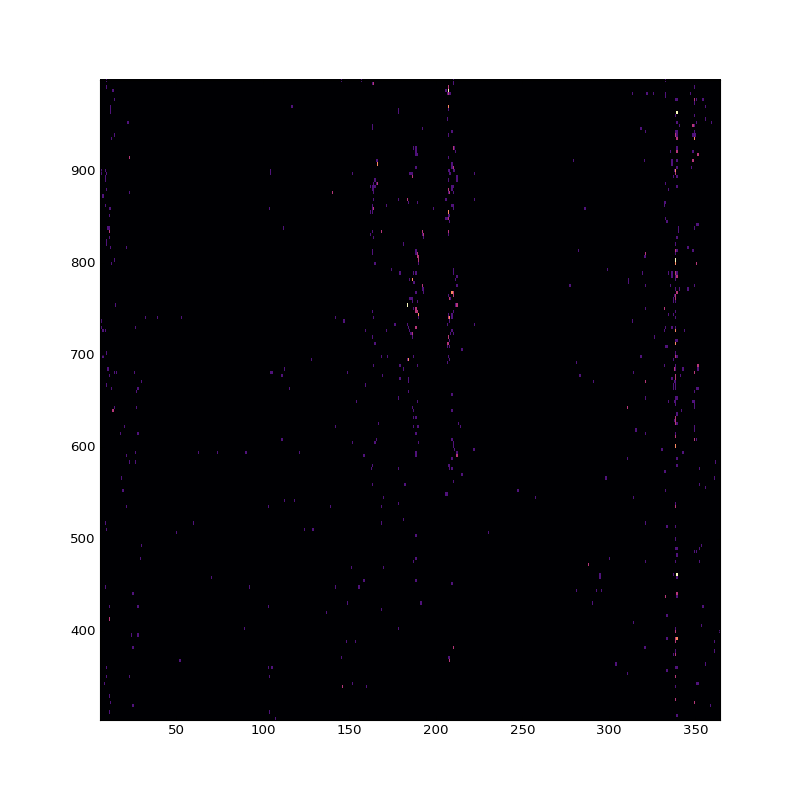

In [19]:
plt.figure(figsize=(10,10))
plt.hist2d([f[1] for f in feature_vector],[f[0] for f in feature_vector], bins=(500,200), cmap='magma')
plt.show()

In [20]:
from sklearn.neighbors import KDTree
#plt.figure()
#plt.plot([f[0] for f in feature_vector],[f[1] for f in feature_vector], '.')
#plt.show()

rt_idx = np.argsort([f[0] for f in feature_vector])
feature_mz = [feature_vector[ii][0] for ii in rt_idx]
feature_rt =[feature_vector[ii][1] for ii in rt_idx]
feature_intensity = [feature_vector[ii][2] for ii in rt_idx]
feature_group = np.zeros(np.shape(feature_mz),dtype=int)-1
group_count = 0
tree = KDTree(np.asarray([[rt for rt in feature_rt], feature_mz]).T, leaf_size=2)    
for ii in range(len(feature_mz)):

    rt = feature_rt[ii]
    mz = feature_mz[ii]
    gp = feature_group[ii]
    if ii in [3656,3649]:
        print 'loadinfo',mz,rt,gp
        
    if gp == -1:
        gp = group_count
        group_count+=1
        feature_group[ii] = gp
    q = np.reshape([rt, mz+1.003355],(2,1))
    dist, near_ix = tree.query(q.T)
    near_ix = near_ix[0][0]
    delta_rt =  np.abs(q[0] - feature_rt[near_ix])
    delta_mz =  np.abs(q[1] - feature_mz[near_ix])
    if all([delta_rt[0]<0.5, delta_mz[0]< 0.1]):
         feature_group[near_ix] = gp
    if ii == 3656:
        print delta_rt, delta_mz
        print near_ix
        print feature_mz[near_ix]
        print feature_rt[near_ix]
        print feature_group[near_ix]
        print all([delta_rt[0]<0.5, delta_mz[0]< 0.1])
        print gp, feature_group[ii], feature_group[near_ix]

print len(feature_vector)
print np.shape(np.unique(feature_group))


835
(685,)


<IPython.core.display.Javascript object>


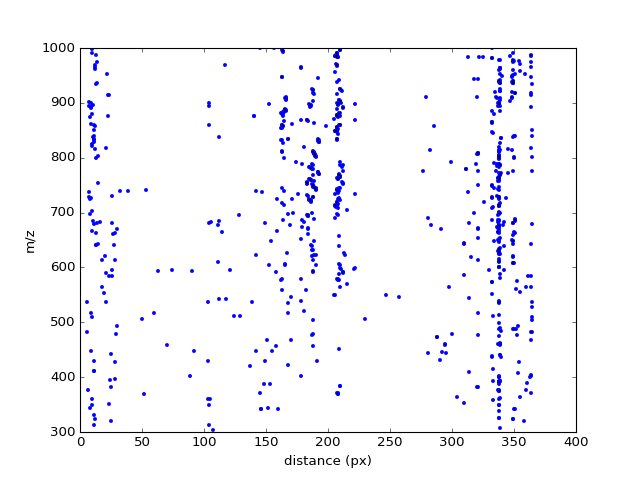

In [21]:
plt.figure()
plt.plot(feature_rt,feature_mz,'.')
for f in np.unique(feature_group):
    this_feature_ix = [ii for ii in range(len(feature_mz)) if feature_group[ii] == f]
    if len(this_feature_ix)<2:
        continue
    this_feature_mz = np.asarray([feature_mz[ii] for ii in this_feature_ix])
    this_feature_rt = np.asarray([feature_rt[ii] for ii in this_feature_ix])
    ix = np.argsort(this_feature_mz)
    plt.plot(this_feature_rt[ix],this_feature_mz[ix],color='black')
    plt.ylabel('m/z')
    plt.xlabel('distance (px)')
plt.show()

In [22]:
# Get feature groups (more than one isotope peak)
features_w_isotopes = []
for f in np.unique(feature_group):
    this_feature_ix = [ii for ii in range(len(feature_mz)) if feature_group[ii] == f]
    if len(this_feature_ix)<2:
        continue
    this_feature_mz = np.asarray([feature_mz[ii] for ii in this_feature_ix])
    this_feature_rt = np.asarray([feature_rt[ii] for ii in this_feature_ix])
    ix = np.argsort(this_feature_mz)
    features_w_isotopes.append([this_feature_mz[ix][0],this_feature_rt[ix][0]])

In [23]:
print len(features_w_isotopes)

113


In [24]:
# Load lipid database
lipid_db = pd.read_csv('/Users/palmer/Documents/Projects/2015/SM_development/databases_in/swiss_lipids_quick_Species.csv')
#lipid_db = pd.read_csv('/Users/palmer/Documents/Projects/2015/SM_development/databases_in/swiss_lipids_quick_structuralSubspecies.csv')
#lipid_db = pd.read_csv('/Users/palmer/Documents/Projects/2015/SM_development/databases_in/swiss_lipids_quick.csv')
lipid_db[lipid_db.isnull()]=np.nan
lipid_db=lipid_db.fillna(0)
print np.shape(lipid_db)
# Check for features for each lipid


(8932, 7)


In [25]:
peak_dict={}
for mz in np.unique(lipid_db[["+H","+Na","+K"]].values):
    ion_datacube = ims_dataset.get_ion_image(mz,[ppm,])
    im = ion_datacube.xic_to_image(0)
    im=im_smoothing.median(im,size=3)
    m_s = np.mean(im,axis=0)
    m_s_f_s = smooth_chrom(m_s, w_size=w)
    m_s_f_s_c = centroid_detection.gradient(np.asarray(range(np.shape(m_s_f)[0])), np.asarray(m_s_f_s), min_intensity=min_int)    
    peak_dict[mz]=m_s_f_s_c[0:]
print 'done'

done


In [26]:
# Get all lipid prefixes from database
#def lipid_to_subclass(lipid_name):
    
lipid_prefix = set()
for lipid_name in lipid_db['name']:
    if any((":" not in lipid_name, lipid_name.startswith("("))):
        continue
    if "[" in lipid_name:
        lipid_prefix.add(lipid_name[0:min((lipid_name.index("[")+1,))])
    else:
        lipid_prefix.add(lipid_name[0:min((lipid_name.index("(")+1,))])
lipid_prefix = list(lipid_prefix)

# Go through database and list possible features that correspond to each lipid, grouped by species
peak_by_species = {}
for prefix in lipid_prefix:
    peak_by_species[prefix]=[]
    
for lipid in lipid_db.iterrows():
    lipid=lipid[1]
    if any((":" not in lipid['name'], lipid['name'].startswith("("))):
        continue
    if "[" in lipid['name']:
        this_lipid_prefix = lipid['name'][0:min((lipid['name'].index("[")+1,))]
    else:
        this_lipid_prefix = lipid['name'][0:min((lipid['name'].index("(")+1,))]
    for adduct in ("+H","+Na","+K"):
        peaks = peak_dict[lipid[adduct]]
        if list(peaks[0]) != []:
            peak_by_species[this_lipid_prefix].extend(peaks[0])

<IPython.core.display.Javascript object>


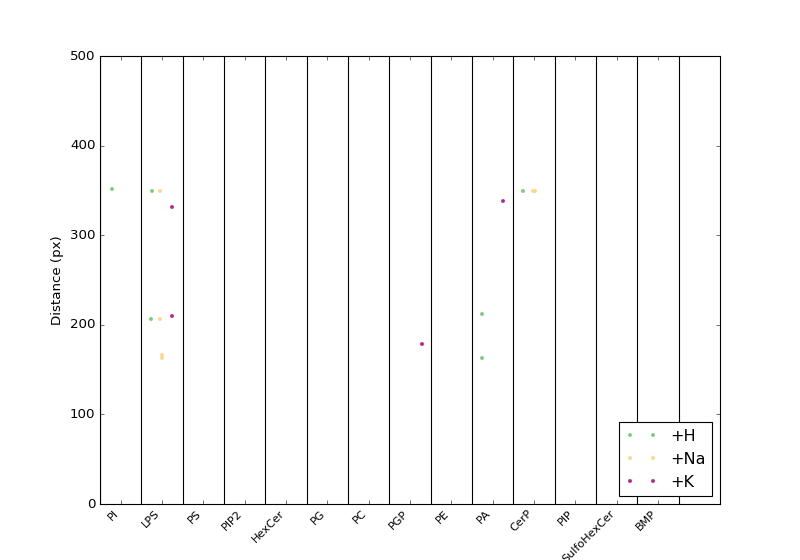

In [27]:
# Check features_w_isotopes against database 
# unique match
adducts = ["+H","+Na","+K"]
plt.figure(figsize=(10,7))
for ia, adduct in enumerate(adducts):
    features_w_isotopes_possible_lipid_classes = []
    for [mz,rt] in features_w_isotopes:
        delta_mz = mz*ppm*1e-6
        match_ix = [np.where(np.abs(lipid_db[adduct]-mz)<delta_mz) for adduct in [adduct]]
        match_ix = np.unique([xx for x in match_ix for xx in x[0]])
        lipid_name = lipid_db.ix[match_ix]['name'].values
        lipid_class = [name[0:name.index("(")+1] for name in lipid_name]
        features_w_isotopes_possible_lipid_classes.append(lipid_class)

    lipid_classes = set()
    for x in features_w_isotopes_possible_lipid_classes:
        lipid_classes = set(x)|lipid_classes
    lipid_classes = list(lipid_classes)
    cmap = plt.get_cmap('Accent')
    xx = []
    yy = []
    for lc in lipid_classes:    
        rt = np.asarray([features_w_isotopes[ii][1] for ii in range(len(features_w_isotopes)) 
                         if all([len(features_w_isotopes_possible_lipid_classes[ii])==1, lc in features_w_isotopes_possible_lipid_classes[ii]])])
        mz = np.asarray([features_w_isotopes[ii][0] for ii in range(len(features_w_isotopes)) 
                         if all([len(features_w_isotopes_possible_lipid_classes[ii])==1, lc in features_w_isotopes_possible_lipid_classes[ii]])])
        li = np.where([lp==lc for lp in lipid_prefix])[0]
        xx.extend(ia/4.-0.25+li+np.random.randn(len(rt))/50.)
        yy.extend(rt)
    plt.plot(xx,yy, '.', color=cmap(ia/3.), linewidth=0)
for l in range(len(lipid_classes)+1):
    plt.plot([l-0.5,l-0.5],[0,500], color="black")
plt.xticks(range(len(lipid_classes)), [lc[0:-1] for lc in lipid_classes], rotation=45, fontsize=10, ha='right')
plt.xlim((-0.5,len(lipid_classes)+0.5))
plt.ylim((0,500))
plt.legend(adducts, loc=4)
plt.ylabel('Distance (px)')
plt.xlabel('Lipid Species')
plt.show()

In [28]:
# Check features_w_isotopes against database
# adduct present at same place for all three
features_w_isotopes_possible_lipid_classes = []
mz = []
rt=[]
lipid=[]
for lipid in lipid_db.iterrows():
    mzs = [lipid[1][adduct] for adduct in adducts]

<IPython.core.display.Javascript object>


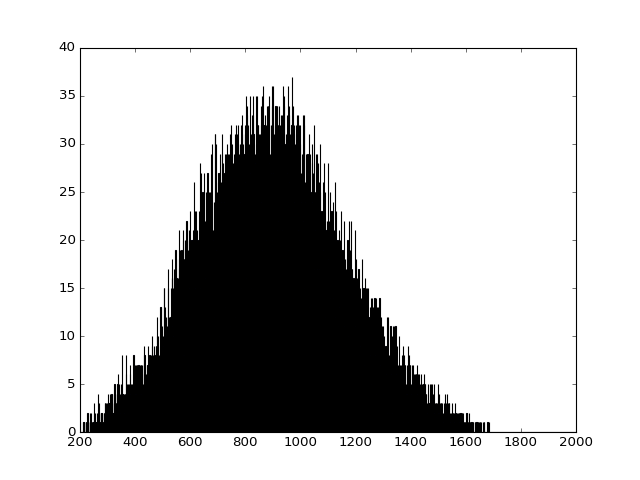

<IPython.core.display.Javascript object>


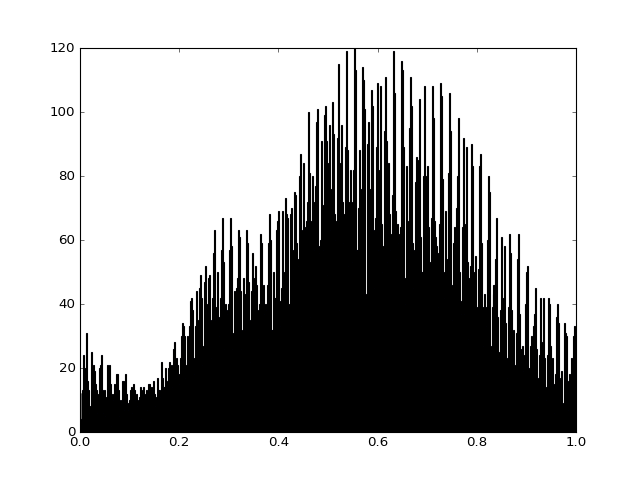

In [29]:
plt.figure()
plt.hist(peak_dict.keys(), bins=np.linspace(200,2000,4000))
plt.show()
plt.figure()
plt.hist([p-int(p) for p in peak_dict.keys()], bins=np.linspace(0,1,500))
plt.show()

In [30]:
# Count database matches
print len(peak_dict)
print np.sum([list(peak_dict[p][0])!=[] for p in peak_dict])

23121
383


<IPython.core.display.Javascript object>


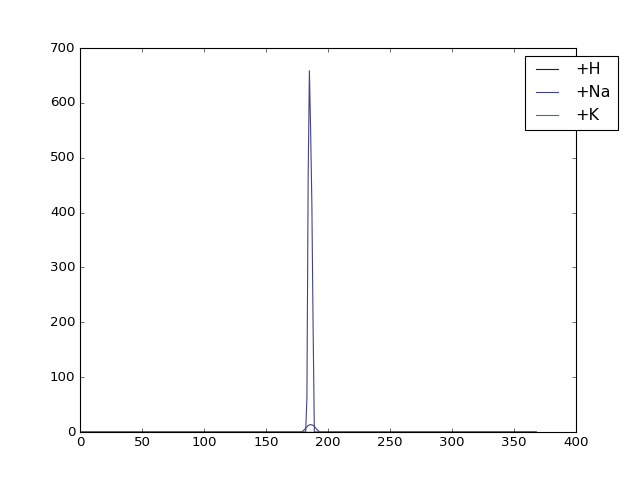

In [31]:
lipid_name = "PC(32:0)"
lipid_entry = lipid_db[lipid_db.name==lipid_name]
# Check some chromatograms0
n_samp=5
cmap = plt.get_cmap('viridis')
plt.figure()
for ii,adduct in enumerate(["+H", "+Na", "+K"]):
    mz = lipid_entry[adduct].values[0]
    ion_datacube = ims_dataset.get_ion_image(lipid_entry[adduct].values,[ppm,])
    im = ion_datacube.xic_to_image(0)
    im=im_smoothing.median(im,size=3)
    m_s = np.mean(im,axis=0)
    m_s_f_s = smooth_chrom(m_s, w_size=w)
    
    plt.plot(m_s, label=adduct, color=cmap(float(ii)/n_samp))
    plt.plot(m_s_f_s, color=cmap(float(ii)/n_samp))
    if list(peak_dict[mz][0]) != []:
        markerline, stemlines, baseline = plt.stem( peak_dict[mz][0], peak_dict[mz][1], label=adduct, )
        plt.setp(markerline, 'markerfacecolor', cmap(float(ii)/n_samp))
        plt.setp(baseline, 'color', cmap(float(ii)/n_samp), 'linewidth', 2)
        plt.setp(stemlines, 'color', cmap(float(ii)/n_samp), 'linewidth', 2)
plt.legend( bbox_to_anchor= (1.,0.,0.1,1.))
plt.show()

<IPython.core.display.Javascript object>


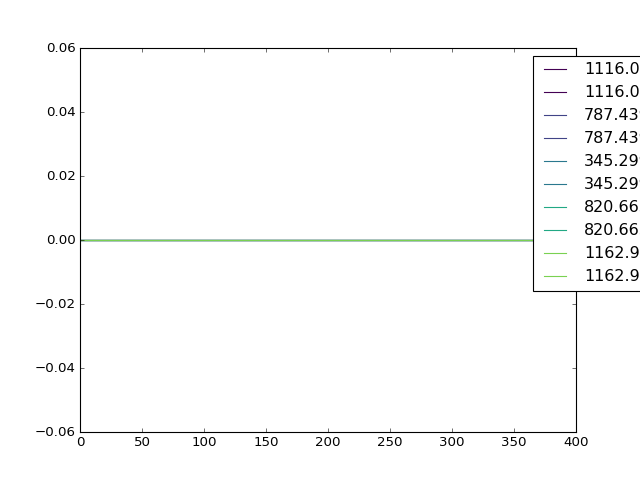

In [32]:
# Check some chromatograms
n_samp=5
cmap = plt.get_cmap('viridis')
plt.figure()
for ii,mz in enumerate(np.random.choice(np.unique(lipid_db[["+H","+Na","+K"]].values),size=n_samp)):
    ion_datacube = ims_dataset.get_ion_image(mz,[ppm,])
    im = ion_datacube.xic_to_image(0)
    im=im_smoothing.median(im,size=3)
    m_s = np.mean(im,axis=0)
    m_s_f_s = smooth_chrom(m_s, w_size=w)
    
    plt.plot(m_s, label=mz, color=cmap(float(ii)/n_samp))
    plt.plot(m_s_f_s, label=mz, color=cmap(float(ii)/n_samp))
    if list(peak_dict[mz][0]) != []:
        markerline, stemlines, baseline = plt.stem( peak_dict[mz][0], peak_dict[mz][1], label=mz, )
        plt.setp(markerline, 'markerfacecolor', cmap(float(ii)/n_samp))
        plt.setp(baseline, 'color', cmap(float(ii)/n_samp), 'linewidth', 2)
        plt.setp(stemlines, 'color', cmap(float(ii)/n_samp), 'linewidth', 2)
plt.legend( bbox_to_anchor= (1.,0.,0.3,1.))
plt.show()

/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


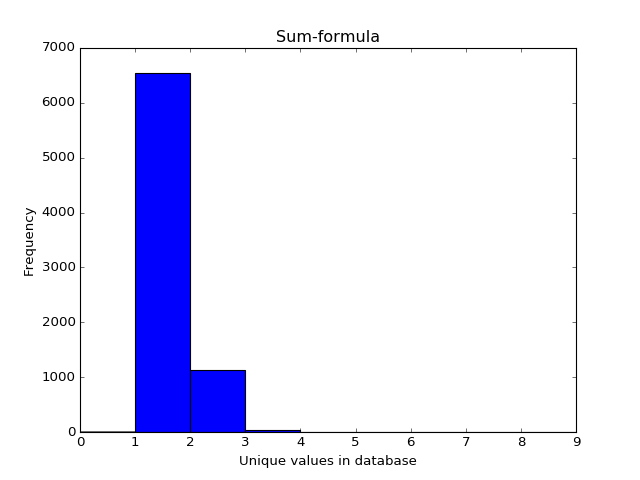

<IPython.core.display.Javascript object>


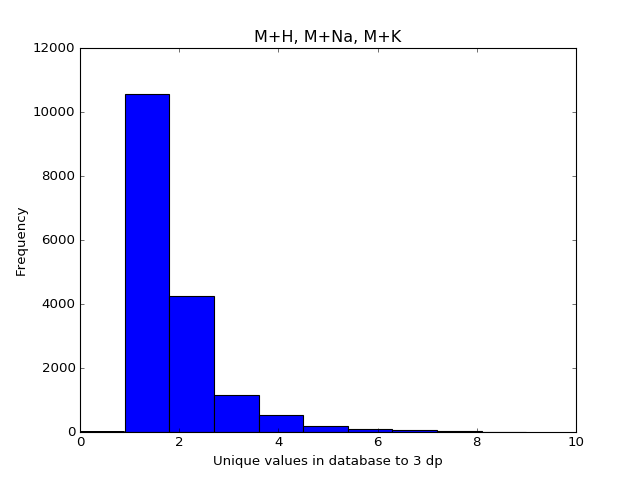

In [33]:
n_dp=3
def my_round(x):
    return np.round(x,decimals=2)
# Sum formula degenearcy
plt.figure()
plt.hist(lipid_db.sf.value_counts(), bins=range(0,10))
plt.title("Sum-formula".format(n_dp))
plt.xlabel('Unique values in database')
plt.ylabel('Frequency')
plt.show()

plt.figure()
plt.hist(np.bincount(np.digitize(lipid_db[["+H","+Na","+K"]].applymap(my_round).values.ravel(), np.unique(lipid_db[["+H","+Na","+K"]].applymap(my_round).values.ravel()))))
plt.title("M+H, M+Na, M+K")
plt.xlabel('Unique values in database to {} dp'.format(n_dp))
plt.ylabel('Frequency')
plt.show()

<IPython.core.display.Javascript object>


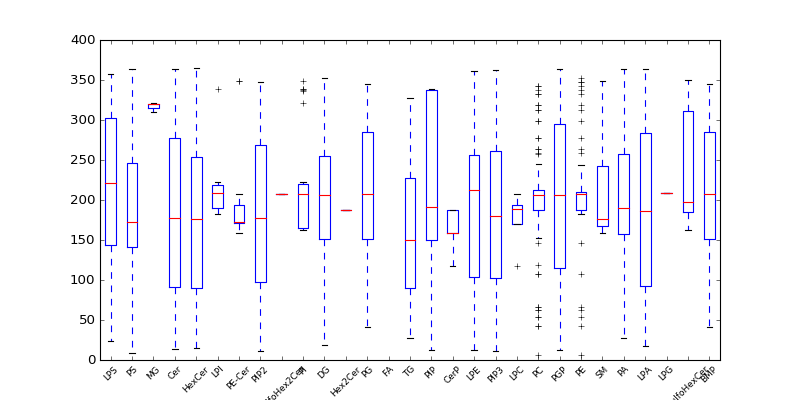

<IPython.core.display.Javascript object>


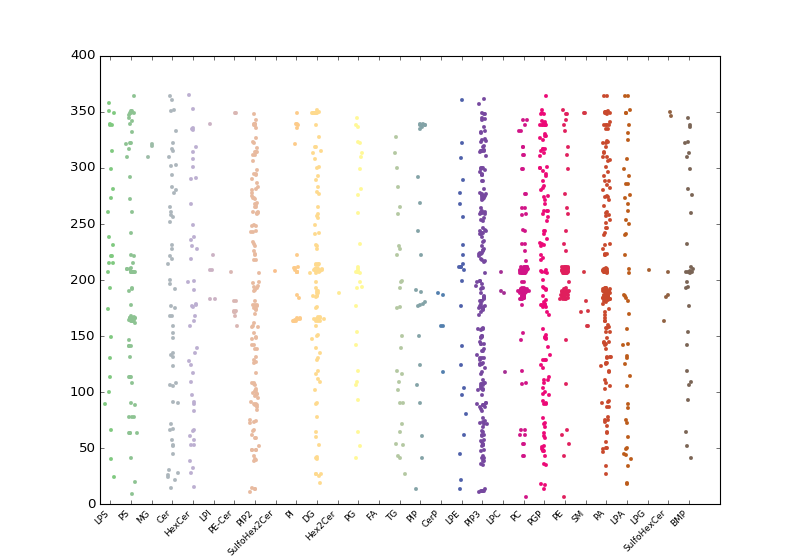

In [34]:
plt.figure(figsize=(10,5))
plt.boxplot([peak_by_species[p] for p in peak_by_species], labels=[p[0:-1] for p in peak_by_species.keys()])
xtickNames = plt.setp(plt.gca(), xticklabels=[p[0:-1] for p in peak_by_species.keys()])
plt.setp(xtickNames, rotation=45, fontsize=8)
plt.show()

cmap = plt.get_cmap('Accent')
#plt.figure(figsize=(10,7))
#for ii,p in enumerate(peak_by_species):
#    h = np.histogram(peak_by_species[p],bins=np.linspace(0,500,150))
#    plt.plot(h[1][1:],h[0],label=p[0:-1],color=cmap(ii/float(len(peak_by_species))))
#plt.legend(bbox_to_anchor = (1.,0.,0.2,1.))
#plt.show()

plt.figure(figsize=(10,7))
for ii,p in enumerate(peak_by_species):
    plt.plot(ii+np.random.randn(len(peak_by_species[p]))/10., peak_by_species[p], '.', color=cmap(ii/float(len(peak_by_species))))
plt.xticks(range(len(peak_by_species)), [p[0:-1] for p in peak_by_species.keys()], rotation=45, fontsize=8, ha='right')
plt.xlim((-0.5,len(peak_by_species)+0.5))
plt.show()



In [35]:
adducts = ("+H","+Na","+K")
n_adducts = len(adducts)
n_lipids = np.shape(lipid_db)[0]
master_table = [[[p for p in peak_dict[lipid[1][adduct]][0]] for adduct in adducts] for lipid in lipid_db.iterrows() ]
lipid_names = [lipid[1]['name'] for lipid in lipid_db.iterrows() ]

print np.shape(master_table)
print np.shape(lipid_db)

(8932, 3)
(8932, 7)


In [36]:
print master_table[0]

[[], [], []]


In [37]:
def foo(lipid_names, master_table):
    for ii in reversed(range(len(master_table))):
        if any([any([j>0 for j in jj]) for jj in master_table[ii]]) == False:
            master_table.pop(ii)
            lipid_names.pop(ii)
    return lipid_names, master_table
lipid_names, master_table = foo(lipid_names, master_table)

In [38]:
print len(master_table)/float(np.sum([list(peak_dict[p][0])!=[] for p in peak_dict]))


1.0861618799


In [39]:
master_mz = {}
for lipid_name in lipid_names:
    ll=lipid_db.ix[lipid_db['name']==lipid_name]
    master_mz[lipid_name] = [ll[a].values[0] for a in adducts]    

<IPython.core.display.Javascript object>


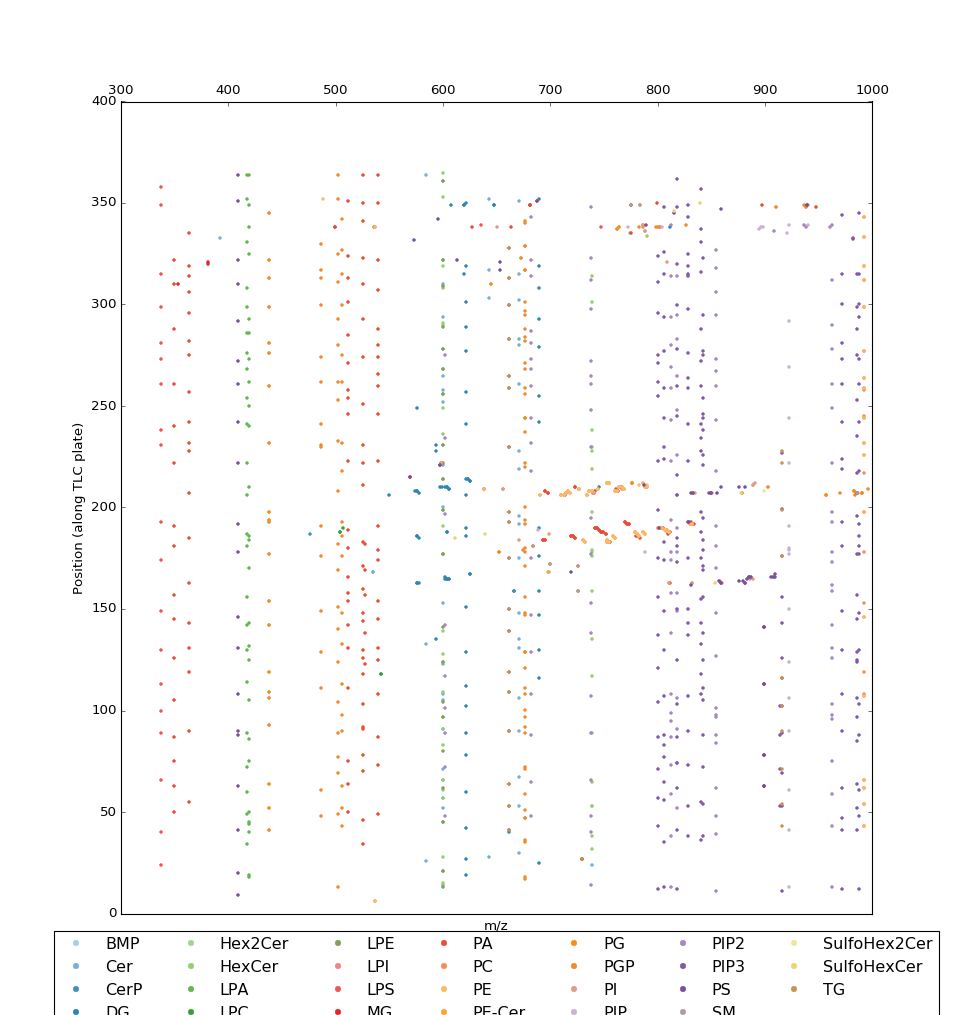

In [40]:
fig = plt.figure(figsize=(10,10))
cmap=plt.get_cmap('Paired')
for ii, pre in enumerate(sorted(lipid_prefix)):
    for a in range(3):
        mzs = []
        defect = []
        pos = []        
        ad_hist = []
        for jj in range(len(lipid_names)):
            if lipid_names[jj].startswith(pre):
                mz = master_mz[lipid_names[jj]][a]
                for p in master_table[jj][a]:
                    mzs.extend([mz,])
                    defect.extend([mz-int(mz),])
                    pos.extend([p,])
        #ax = fig.add_subplot(1,3,a+1)
        if len(pos) > 0:
            ax=fig.add_subplot(1,1,1)
            lab=None
            if a==0:
                lab=pre[0:pre.index('(')]
            ax.plot(mzs, pos, '.', markersize=5, label=lab, color=cmap(ii/float(len(lipid_prefix))))
            ax.xaxis.tick_top()

plt.legend(bbox_to_anchor=(-0.1, -0.15, 1.2, .1), loc=3,
           ncol=7, mode="expand", numpoints = 1, markerscale=2, markerfirst=True)
plt.ylabel('Position (along TLC plate)')
plt.xlabel('m/z')
plt.show()

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
"""
pos_ax = np.linspace(0,500,100)
mz_ax=np.linspace(500,2000,9000)
for ii, pre in enumerate(sorted(lipid_prefix)):
    fig = plt.figure(figsize=(10,7))
    ax_pos=fig.add_subplot(1,2,1)
    plt.ylabel('frequency')
    plt.xlabel('Position (along TLC plate)')
    ax_mz=fig.add_subplot(1,2,2)
    plt.ylabel('frequency')
    plt.xlabel('m/z')
    for a in range(3):
        mzs = []
        defect = []
        pos = []        
        ad_hist = []
        for jj in range(len(lipid_names)):
            if lipid_names[jj].startswith(pre):
                mz = master_mz[lipid_names[jj]][a]
                for p in master_table[jj][a]:
                    mzs.extend([mz,])
                    defect.extend([mz-int(mz),])
                    pos.extend([p,])
        ad_hist=np.histogram2d(pos, mzs, bins = (pos_ax, mz_ax))
        ax_pos.plot(pos_ax[1:], np.sum(ad_hist[0],axis=1), label=adducts[a])
        ax_mz.plot(mz_ax[1:], np.sum(ad_hist[0],axis=0), label=adducts[a])
    
    plt.legend(bbox_to_anchor=(0., -0.15, 0.99, .102), loc=3,
           ncol=7, mode="expand",numpoints = 1)
    plt.title(pre)
    plt.show()
"""

'\npos_ax = np.linspace(0,500,100)\nmz_ax=np.linspace(500,2000,9000)\nfor ii, pre in enumerate(sorted(lipid_prefix)):\n    fig = plt.figure(figsize=(10,7))\n    ax_pos=fig.add_subplot(1,2,1)\n    plt.ylabel(\'frequency\')\n    plt.xlabel(\'Position (along TLC plate)\')\n    ax_mz=fig.add_subplot(1,2,2)\n    plt.ylabel(\'frequency\')\n    plt.xlabel(\'m/z\')\n    for a in range(3):\n        mzs = []\n        defect = []\n        pos = []        \n        ad_hist = []\n        for jj in range(len(lipid_names)):\n            if lipid_names[jj].startswith(pre):\n                mz = master_mz[lipid_names[jj]][a]\n                for p in master_table[jj][a]:\n                    mzs.extend([mz,])\n                    defect.extend([mz-int(mz),])\n                    pos.extend([p,])\n        ad_hist=np.histogram2d(pos, mzs, bins = (pos_ax, mz_ax))\n        ax_pos.plot(pos_ax[1:], np.sum(ad_hist[0],axis=1), label=adducts[a])\n        ax_mz.plot(mz_ax[1:], np.sum(ad_hist[0],axis=0), label=ad

In [42]:
def count_carbon(name_str):
    name_str = name_str[name_str.index("(")+1:name_str.index(")")]
    name_str = name_str.replace("P-","")
    name_str = name_str.replace("O-","")
    name_str = name_str.replace("d","")
    name_str = name_str.replace("t","")

    c_count = []
    dbl_count = []
    for piece in name_str.split("/"):
        c,d = piece.split(":")
        c_count.append(int(c))
        dbl_count.append(int(d))
    return c_count, dbl_count

markers = ["o", "v", "^", "<", ">", "1", "2", "3", "4", "s", "p", "*", "h", "H", "+", "x", "D", "d", "|", "_", ".", "s"]
mzs = []
defect = []
pos = []
carbons =[]
c_ratio = []
dbls = []
mrk = []
for ii, pre in enumerate(sorted(lipid_prefix)):
    for jj in range(len(lipid_names)):
        if lipid_names[jj].startswith(pre):
            c,d = count_carbon(lipid_names[jj])
            for a in range(3):
                mz = master_mz[lipid_names[jj]][a]
                for p in master_table[jj][a]:
                    c_ratio.append(max(c) / float(min([cc for cc in c if cc>0])))
                    carbons.append(sum(c))
                    dbls.append(sum(d))
                    mzs.extend([mz,])
                    defect.extend([mz-int(mz),])
                    pos.extend([p,])
                    mrk.append(markers[list(lipid_prefix).index(pre)%len(markers)])

In [43]:
print lipid_names[jj]
print float(min([cc for cc in c if cc>0]))
print max(c) / float(min([cc for cc in c if cc>0]))

BMP(9:0) | LBPA(9:0)
57.0
1.0


<IPython.core.display.Javascript object>


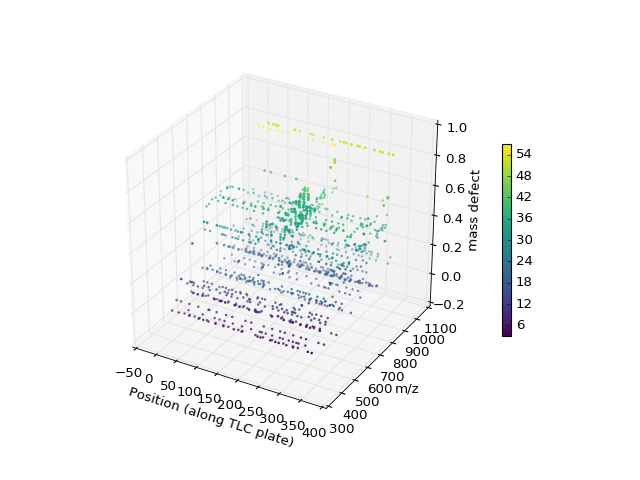

In [44]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(pos, mzs, defect, c=carbons, marker=".", linewidth=0, cmap=cm.viridis)
fig.colorbar(p, shrink=0.5)
ax.set_xlabel('Position (along TLC plate)')
ax.set_ylabel('m/z')
ax.set_zlabel('mass defect') 
plt.show()

<IPython.core.display.Javascript object>


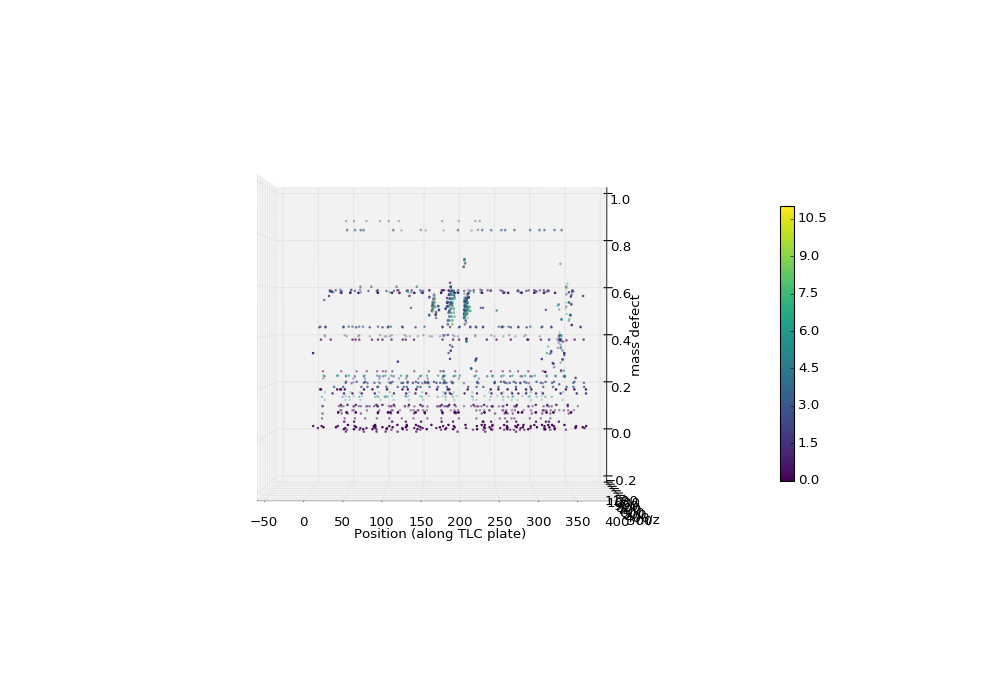

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(pos, mzs, defect, c=dbls, marker=".", linewidth=0, cmap=cm.viridis)
#plt.legend(sorted(lipid_prefix), bbox_to_anchor=(0., -0.1, 0.99, .102), loc=3,
#           ncol=7, mode="expand",numpoints = 1)
fig.colorbar(p, shrink=0.5)
ax.set_xlabel('Position (along TLC plate)')
ax.set_ylabel('m/z')
ax.set_zlabel('mass defect') 
plt.show()

<IPython.core.display.Javascript object>


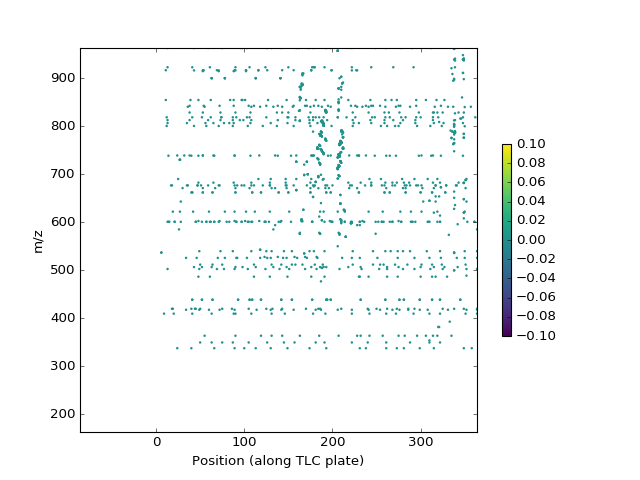

In [46]:
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
p = ax.scatter(pos, mzs, c=np.log(c_ratio), marker=".", linewidth=0, cmap=cm.viridis)
#plt.legend(sorted(lipid_prefix), bbox_to_anchor=(0., -0.1, 0.99, .102), loc=3,
#           ncol=7, mode="expand",numpoints = 1)
fig.colorbar(p, shrink=0.5)
ax.set_xlabel('Position (along TLC plate)')
ax.set_ylabel('m/z')
#ax.set_zlabel('mass defect') 
plt.show()

In [47]:
# Print total number of lipids with a peak
print len(lipid_names)
print lipid_db.head()
lipid_present_list = []
for lipid in lipid_db.iterrows():
    for adduct in adducts:
        mz = lipid[1][adduct]
        if len(peak_dict[mz][0]) > 0:
            lipid_present_list.append([lipid[1]['name'],adduct,mz,peak_dict[mz][0]])
print len(lipid_present_list)
print lipid_present_list

416
              id      name  mw_exact        sf          +H         +Na  \
0  SLM:000001105  FA(18:4)  275.4063  C18H27O2  276.208382  298.190326   
1  SLM:000001251   FA(3:0)   73.0711    C3H5O2   74.036231   96.018175   
2  SLM:000001252   FA(4:0)   87.0977    C4H7O2   88.051881  110.033825   
3  SLM:000001253   FA(6:0)  115.1509   C6H11O2  116.083181  138.065125   
4  SLM:000001254   FA(8:0)  143.2040   C8H15O2  144.114481  166.096425   

           +K  
0  314.164263  
1  111.992112  
2  126.007762  
3  154.039062  
4  182.070363  
487
[['LPA(36:4)', '+H', 681.485368, array([ 349.00038009])], ['LPA(O-15:0)', '+K', 419.19593381, array([  18.00132879,   18.99956657,   40.00012898,   44.00116269,
         44.99983322,   50.00041696,   74.99898981,   86.00003081,
        104.99981181,  125.00107183,  132.00009401,  143.00115743,
        170.00135955,  183.99995352,  185.99993519,  209.99887859,
        239.99913364,  250.00002057,  261.99958748,  272.99932888,
        285.99856721, 